# 1. MDP definition

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r_A = 2
r_B = 1
c   = 3
gamma=0.9

In [4]:
#Define a policy
p_a = 0.95
p_b = 0.95
P_pi = np.array([[p_a,1-p_a],[1-p_b,p_b]])
print P_pi

#Compute the expected reward vector r_pi
r_pi = np.array([(r_A * P_pi[0,0]+(r_B-c)*P_pi[0,1]),
                 (r_B * P_pi[1,1]+(r_A-c)*P_pi[1,0])])
             
print "r_pi =", r_pi


[[ 0.95  0.05]
 [ 0.05  0.95]]
r_pi = [ 1.8  0.9]


Recall $v_{\pi}$ can be computed analytically using the following formula:
$$
v_{\pi} = (I - \gamma P_{\pi})^{-1} r_{\pi}
$$

In [5]:
#Compute value function analytically
v_pi = np.dot(
    1/((1-gamma*P_pi[0,0])*(1-gamma*P_pi[1,1])-gamma*gamma*P_pi[0,1]*P_pi[1,0]) * 
    np.array([[1-gamma*P_pi[1,1],gamma*P_pi[0,1]],[gamma*P_pi[1,0],1-gamma*P_pi[0,0]]])
    ,r_pi)

#The following line can also be used
#v_pi = np.dot(np.linalg.inv(np.identity(2)-gamma*P_pi),r_pi)

print "v_pi = ", v_pi

v_pi =  [ 15.86842105  11.13157895]


# 2. Policy evaluation algorithm

In [6]:
#policy evaluation algorithm
def policy_evaluation(P_pi, #transition matrix for policy pi
                      v_init, #initial guess of the value function
                      v_pi, #true value function
                      theta=10**(-7), #convergence tolerance threshold (default 10^-7)
                      N_max=1000, #maximum number of iterations (default is 1000)
                      show_graphs=False #whether to show convergence graphs or not (default is False)
                     ): 
    
    print "Running policy evaluation..."
    
    err=np.zeros(N_max+1) #approximation error, ie err_k = | v_k - v_pi |
    log_sigma=np.zeros(N_max+1) #logarithm of empirical average convergence rate
                                #we only record the logarithm for numerical stability
    var_err = np.zeros(N_max+1) #variation of the error, ie var_err_k = | err_k / err_{k-1} |
    V=np.zeros((N+1,np.size(v_pi))) #sequence of error vectors, ie V_k = v_k - v_pi
    
    #define initial value function
    v_approx= v_init
    v_temp = np.zeros(np.size(v_init)) #used to store updates of v_approx
    
    #initial error
    err[0] = np.max(np.abs(v_approx- v_pi))
    V[0,:]=v_approx-v_pi
    
    epsilon = theta+1 #perform at least one iteration
    count=1 #counts the number of iterations
    
    #=============================
    #  RUN POLICY EVALUATION
    #=============================
    
    while(epsilon>theta and count<=N_max):
        epsilon = 0
    
        #perform one sweep
        v_temp = r_pi+gamma*np.dot(P_pi,v_approx)
    
        #compute max change in the value function
        epsilon = np.max(np.abs(v_approx-v_temp))
        #update value function
        v_approx=v_temp
        V[count,:]=v_approx-v_pi
    
        #compute new error, error variation, and average convergence rate so far
        err[count] = np.max(np.abs(v_approx- v_pi))
        var_err[count]=err[count]/err[count-1]
        log_sigma[count] = (1.0/count) * (np.log(err[count])-np.log(err[0]))
        
        #increment iterations count
        count=count+1
    
    #termination message
    if (count >N_max): #convergence failed
        print "\tReached max iterations (", N_max, ")"
        print "\tLast improvement:", epsilon, ">", theta
    else: #succesful convergence
        print "\tConvergence reached after", count-1, "iterations"
        print "\tLast improvement:", epsilon, "<", theta
    
    #free some space in memory
    err=err[range(count)]
    log_sigma = log_sigma[range(count)]
    var_err=var_err[range(count)]
    V=V[range(count),:]
    
    
    #un-comment the following line if you want to update the initial value function in place
    #in any case, the final value function is returned to caller
    #v_init = v_approx
    
    return (v_approx,err,var_err,log_sigma,V)

In [7]:
theta = 10 ** (-7) #convergence tolerance
N=1000 #maximum number of iterations
v_approx= np.array([0,0]) #initial guess

#perform policy evaluation
(v_approx,err,var_err,log_sigma,V) = policy_evaluation(P_pi, v_approx, v_pi,theta,N,True)


Running policy evaluation...
	Convergence reached after 157 iterations
	Last improvement: 9.82121584059e-08 < 1e-07


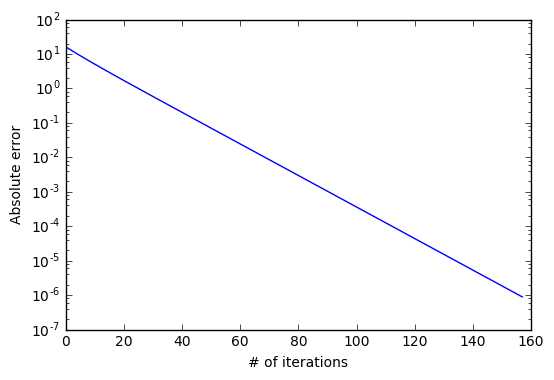

Empirical slope :  -0.0455812506532
Theoretical slope: -0.0457574905607


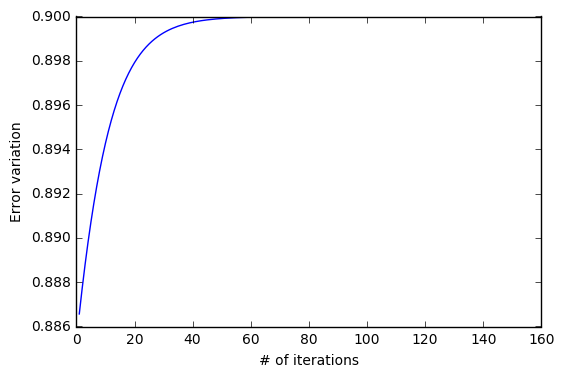

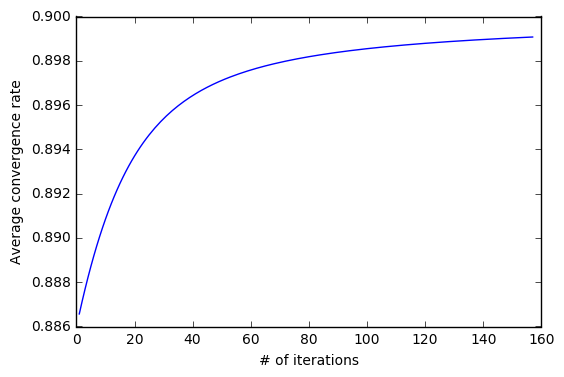

In [10]:
n=np.size(err)
    
#plot infinite norm of the error, in semi-log scale
plt.semilogy(range(n),err[range(n)])
plt.xlabel("# of iterations")
plt.ylabel("Absolute error")
plt.show()

#compute empirical slope
print "Empirical slope : ", (-np.log10(err[1])+np.log10(err[n-1]))/(n)
print "Theoretical slope:", np.log10(gamma)

#plot variation in the error norm
plt.plot(range(1,n),var_err[range(1,n)])
plt.xlabel("# of iterations")
plt.ylabel("Error variation")
plt.show()
    
#plot average rate of convergence
#See Section 3.2 of Varga - Matrix Iterative Analysis
plt.plot(range(1,n),np.exp(log_sigma[range(1,n)]),'b') #empirical
plt.xlabel("# of iterations")
plt.ylabel("Average convergence rate")
plt.show()

# 3. Expression in the eigenbasis of $P_{\pi}$

Recall the following iterative rule:
$$
\varepsilon_{k} = \gamma P_{\pi} e_{k-1} = \gamma^{k} P_{\pi}^{k} \varepsilon_{0}
$$

In the eigenbasis of $P_{\pi}$ (assuming such an eigenbasis exists):
$$
\varepsilon_{k} =
\gamma^{k}
\left(
\begin{array}{ccc}
\lambda_{1}^{k} & 0 & 0 \\
0 & \ddots & 0 \\
0 & 0 & \lambda_{|S|}^{k}
\end{array}
\right)
\varepsilon_{0}
$$

Thus, if we project on eigenvector $w$ associated to eigenvalue $\lambda$, we expect the error to shrink geometrically, at rate $\gamma \lambda$

In [11]:
#Compute eigenvalues of P_pi
(e,v)=np.linalg.eig(P_pi)
print e
print v
v[:,1]

[ 1.   0.9]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


array([-0.70710678,  0.70710678])

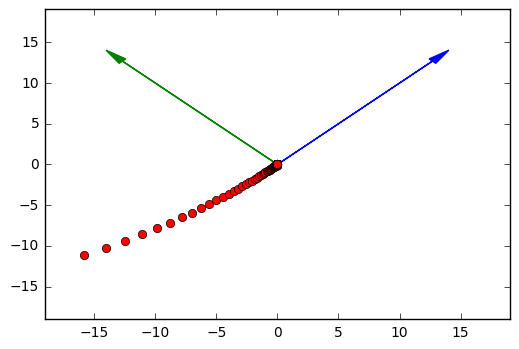

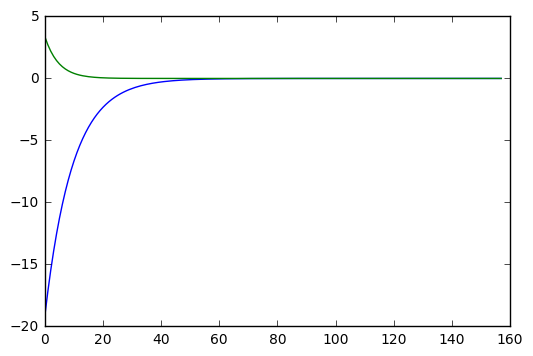

In [12]:
n=np.size(V[:,0])
x_max = 1.2*np.max(np.abs(V[0,:]))

#plot convergence of value function
plt.plot(V[:,0],V[:,1],'ro')
plt.plot([-x_max,-x_max], [x_max,x_max], color='b', linestyle='--')
plt.axis([-x_max,x_max,-x_max,x_max])
ax = plt.axes()

#plot eigenvectors of P_pi
ax.arrow(0,0,x_max/1.5,x_max/1.5,head_width=x_max/25, head_length=x_max/10,fc='b', ec='b')
ax.arrow(0,0,-x_max/1.5,x_max/1.5,head_width=x_max/25, head_length=x_max/10,fc='g', ec='g')

#plt.axes().set_aspect('equal')
plt.show()

#plot projection on eigenspaces
plt.plot(range(n), np.dot(V,v[:,0]),'b')
plt.plot(range(n), np.dot(V,v[:,1]),'g')
plt.show()